In [1]:
from typing import Tuple, List, Dict
from collections import defaultdict
from itertools import product

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dimod

In [2]:
N = 4 # the side of the board

In [3]:
Cell = Tuple[int, int]
Mapping = Dict[Cell, int]

In [4]:
def get_attacks_for_each_cell(cell:Cell) -> List[Cell]:
    """
    Check the attacks for each queen position.
    """

    current_row, current_col = cell

    attacks = []


    for k in range(N):
        current_mapped_col = (k, current_col)
        current_mapped_row = (current_row, k)

        if current_mapped_row != cell:
            attacks.append(current_mapped_row)
        
        if current_mapped_col != cell:
            attacks.append(current_mapped_col)


    # top left
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j > 0:
        current_i -= 1
        current_j -= 1
        attacks.append((current_i, current_j))

    # bottom right
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j < N-1:
        current_i += 1
        current_j += 1
        attacks.append((current_i, current_j))

    # top right 
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j < N-1:
        current_i -= 1
        current_j += 1
        attacks.append((current_i, current_j))

    # bottom left 
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j > 0:
        current_i += 1
        current_j -= 1
        attacks.append((current_i, current_j))

    return attacks

In [5]:
def get_pos_mapping() -> Mapping:
    mapping = {}
    k = 0
    for i in range(N):
        for j in range(N):
            mapping[(i,j)] = k
            k += 1
    return mapping

---

# QUBO

In [62]:
def get_qubo(mapping:Mapping) -> dimod.BinaryQuadraticModel:

    model = dimod.BinaryQuadraticModel(vartype='BINARY')

    constraints = []
    constraint_total_vars = [(f'x{i}',1) for i in mapping.values()]

    for i in range(N):
        constraints.append([])

        for j in range(N):
            pos = (i,j)
            current_pos_map = mapping[pos]
            attacks = get_attacks_for_each_cell(pos)

            for attack in attacks:
                mapped_pos = mapping[attack]
                model.add_quadratic(f'x{mapped_pos}', f'x{current_pos_map}', 1)
            
            # constraint for each board row
            constraints[-1].append((f'x{current_pos_map}', 1))

    for constraint in constraints:
        model.add_linear_equality_constraint(constraint, N*N, -1)
    model.add_linear_equality_constraint(constraint_total_vars, N*N, -1 * N)

    return model

             

In [63]:
mapping = get_pos_mapping()
qubo = get_qubo(mapping)
qubo

BinaryQuadraticModel({'x1': -128.0, 'x0': -128.0, 'x4': -128.0, 'x2': -128.0, 'x8': -128.0, 'x3': -128.0, 'x12': -128.0, 'x5': -128.0, 'x10': -128.0, 'x15': -128.0, 'x9': -128.0, 'x13': -128.0, 'x6': -128.0, 'x11': -128.0, 'x14': -128.0, 'x7': -128.0}, {('x0', 'x1'): 66.0, ('x4', 'x1'): 34.0, ('x4', 'x0'): 34.0, ('x2', 'x1'): 66.0, ('x2', 'x0'): 66.0, ('x2', 'x4'): 32.0, ('x8', 'x1'): 32.0, ('x8', 'x0'): 34.0, ('x8', 'x4'): 34.0, ('x8', 'x2'): 34.0, ('x3', 'x1'): 66.0, ('x3', 'x0'): 66.0, ('x3', 'x4'): 32.0, ('x3', 'x2'): 66.0, ('x3', 'x8'): 32.0, ('x12', 'x1'): 32.0, ('x12', 'x0'): 34.0, ('x12', 'x4'): 34.0, ('x12', 'x2'): 32.0, ('x12', 'x8'): 34.0, ('x12', 'x3'): 34.0, ('x5', 'x1'): 34.0, ('x5', 'x0'): 34.0, ('x5', 'x4'): 66.0, ('x5', 'x2'): 34.0, ('x5', 'x8'): 34.0, ('x5', 'x3'): 32.0, ('x5', 'x12'): 32.0, ('x10', 'x1'): 32.0, ('x10', 'x0'): 34.0, ('x10', 'x4'): 32.0, ('x10', 'x2'): 34.0, ('x10', 'x8'): 66.0, ('x10', 'x3'): 32.0, ('x10', 'x12'): 32.0, ('x10', 'x5'): 34.0, ('x15', 'x

In [64]:
sampler = dimod.ExactSolver()
sampleset = sampler.sample(qubo)
#dwave.inspector.show(sampleset)
sampleset

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 320., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 192., 1),
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 130., 1),
           ...,
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  66., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  96., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 192., 1)],
          dtype=[('sample', 'i1', (16,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(['x0', 'x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']), {}, 'BINARY')

In [65]:
df = sampleset.to_pandas_dataframe()
best_solutions = df[df['energy'] == df['energy'].min()]
best_solutions

,x0,x1,x10,x11,x12,x13,x14,x15,x2,x3,x4,x5,x6,x7,x8,x9,energy,num_occurrences
12296,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0.0,1
32798,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,1


In [70]:
df.to_csv("qubo-solution.csv")

In [66]:
def get_board_from_row(mapping:Mapping, row:pd.Series):
    matrix = [[0]*N for i in range(N)]

    for i in range(N):
        for j in range(N):
            mapped_pos = mapping[(i,j)]
            matrix[i][j] = row[f'x{mapped_pos}']
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

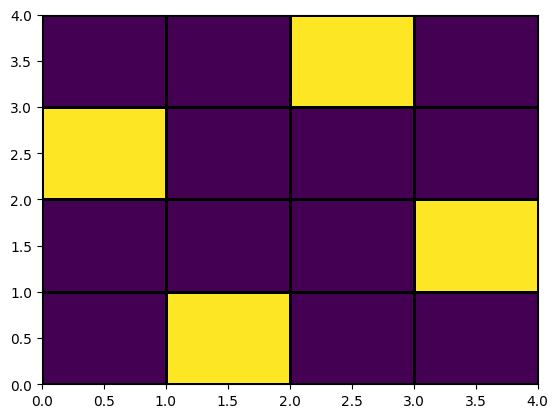

In [69]:
get_board_from_row(mapping, best_solutions.iloc[1])

---

# QAOA

In [6]:
def get_obs(total_qubits:int, qubits:List[int]) -> str:
    obs = ['I']*total_qubits
    for qubit in qubits:
        obs[qubit] = 'Z'
    return ''.join(obs)

In [19]:
Params = List[float]
History = List[float]
def cost_func(params:Params, ansatz:QuantumCircuit, hamiltonian:SparsePauliOp, estimator:EstimatorV2, history:History) -> float:
    """Get the cost of the current circuit"""
    isa_h = hamiltonian.apply_layout(ansatz.layout)
    
    job = estimator.run([(ansatz, isa_h, params)])

    results = job.result()[0]
    cost = abs(results.data.evs)

    history.append(cost)
    print("Current cost: ", cost)

    return cost

In [20]:
def get_H(mapping:Mapping, P:int) -> SparsePauliOp:
  
    total_qubits = len(mapping)

    base_multiplier = 0.25
    comb_factor = P*base_multiplier # for penality
    constant_counter = 0

    lookup = defaultdict(float) # holds obs and coeffs

    const_obs = get_obs(total_qubits, [])
    lookup[const_obs] += 0.0

    for i in range(N):

        for j in range(N):
            pos = (i,j)
            current_pos_map = mapping[pos]
            attacks = get_attacks_for_each_cell(pos)

            for attack in attacks:
                mapped_pos = mapping[attack]

                attack_obs_joint = get_obs(total_qubits, [current_pos_map, mapped_pos])
                ind_1_obs = get_obs(total_qubits, [current_pos_map])
                ind_2_obs = get_obs(total_qubits, [mapped_pos])

                lookup[const_obs] += base_multiplier

                lookup[attack_obs_joint] += base_multiplier
                lookup[ind_1_obs] += base_multiplier
                lookup[ind_2_obs] += base_multiplier

    
    # add one per row constraint
    for i in range(N):

        row = [(i,j) for j in range(N)]
        row_labels = [ mapping[i] for i in row ]
        str_row_labels = list(map(str, row_labels))

        str_row_labels.append(N - 2) # add the normalized C to the end of the values

        for x0,x1 in product(str_row_labels, str_row_labels):
            x0_is_int = isinstance(x0, int)
            x1_is_int = isinstance(x1, int)

            if not x0_is_int and not x1_is_int:
                comb_obs = get_obs(total_qubits, [int(x0)]) if x0 == x1 else get_obs(total_qubits, [int(x0),int(x1)])
                lookup[comb_obs] +=comb_factor

            elif x0_is_int and not x1_is_int:
                comb_obs = get_obs(total_qubits, [int(x1)])
                lookup[comb_obs] += comb_factor * x0

            elif not x0_is_int and x1_is_int:
                comb_obs = get_obs(total_qubits, [int(x0)])
                lookup[comb_obs] += comb_factor * x1

            else:
                
                constant_counter += comb_factor * x0 * x1
    
    # add max N constraint
    all_values = list(mapping.values())
    str_all_values = list(map(str, all_values))
    str_all_values.append(total_qubits - (2*N)) # add normalized C

    for x0,x1 in product(str_all_values,str_all_values):
        x0_is_int = isinstance(x0, int)
        x1_is_int = isinstance(x1, int)

        if not x0_is_int and not x1_is_int:
            comb_obs = get_obs(total_qubits, [int(x0)]) if x0 == x1 else get_obs(total_qubits, [int(x0),int(x1)])
            lookup[comb_obs] += comb_factor

        elif x0_is_int and not x1_is_int:
            comb_obs = get_obs(total_qubits, [int(x1)])
            lookup[comb_obs] += comb_factor * x0

        elif not x0_is_int and x1_is_int:
            comb_obs = get_obs(total_qubits, [int(x0)])
            lookup[comb_obs] += comb_factor * x1

        else:
            constant_counter += comb_factor * x0 * x1

    lookup[const_obs] += constant_counter
    

    return SparsePauliOp.from_list(lookup.items())
    



In [21]:
mapping = get_pos_mapping()

hamiltonian = get_H(mapping, 1)
hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'ZIZIIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIII', 'IIIIIIIIZIIIIIII', 'ZIIZIIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'ZIIIIIIIIIIIZIII', 'IIIIIIIIIIIIZIII', 'ZIIIIZIIIIIIIIII', 'IIIIIZIIIIIIIIII', 'ZIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIII', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZ', 'IZIIIZIIIIIIIIII', 'IZZIIIIIIIIIIIII', 'IZIIIIIIIZIIIIII', 'IIIIIIIIIZIIIIII', 'IZIZIIIIIIIIIIII', 'IZIIIIIIIIIIIZII', 'IIIIIIIIIIIIIZII', 'IZIIIIZIIIIIIIII', 'IIIIIIZIIIIIIIII', 'IZIIIIIIIIIZIIII', 'IIIIIIIIIIIZIIII', 'IZIIZIIIIIIIIIII', 'IIZIIIZIIIIIIIII', 'IIZIIIIIIIZIIIII', 'IIZZIIIIIIIIIIII', 'IIZIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZI', 'IIZIIIIZIIIIIIII', 'IIIIIIIZIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIZIIIIIZIIIIIII', 'IIIZIIIZIIIIIIII', 'IIIZIIIIIIIZIIII', 'IIIZIIIIIIIIIIIZ', 'IIIZIIZIIIIIIIII', 'IIIZIIIIIZIIIIII', 'IIIZIIIIIIIIZIII', 'IIIIZZIIIIIIIIII', 'IIIIZIZIIIIIIIII', 'IIII

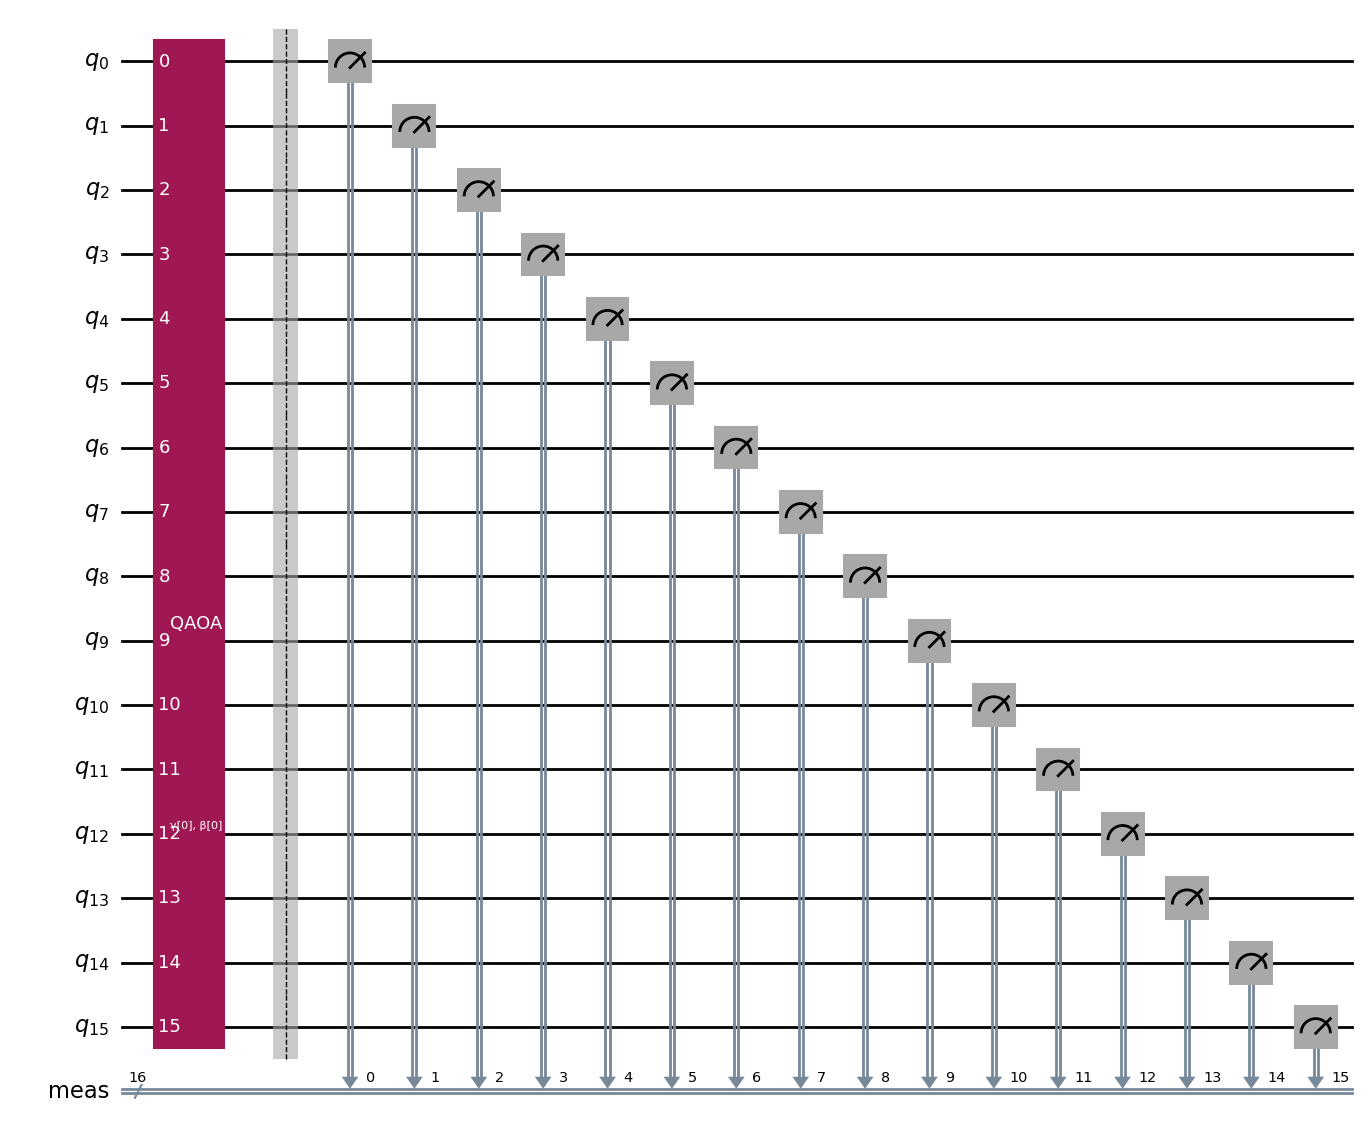

In [22]:

qaoa = QAOAAnsatz(cost_operator=hamiltonian,reps=1)
qaoa.measure_all()
qaoa.draw('mpl')

In [23]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
isa_qc = pm.run(qaoa)

In [ ]:
history = []
estimator = EstimatorV2()
init_params = [np.random.uniform(low=0.0, high=(int(i%2==0)+1)*np.pi, size=1)[0] for i in range(len(isa_qc.parameters))]
print(init_params)
result = minimize(
        cost_func,
        init_params,
        args=(isa_qc, hamiltonian, estimator, history),
        method="COBYLA",
        tol=1e-4,
    )

[np.float64(3.8463847598909493), np.float64(1.61346087441243)]
Current cost:  58.2822265625
Current cost:  57.1533203125
Current cost:  59.7763671875
Current cost:  59.26171875
Current cost:  58.7958984375
Current cost:  54.6005859375
Current cost:  57.9736328125
Current cost:  59.392578125
Current cost:  58.8154296875


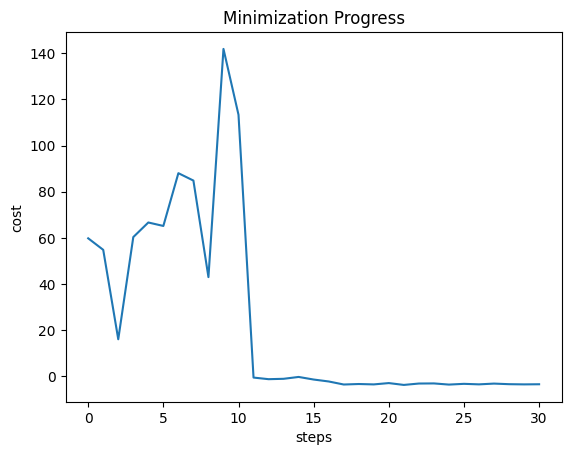

In [14]:
plt.title("Minimization Progress")
plt.plot(list(range(len(history))), history)
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [15]:
print(result.x)
answer_qc = isa_qc.assign_parameters(result.x)

[5.69732353 3.08925951]


In [16]:
sampler = SamplerV2()
job = sampler.run([answer_qc], shots=1000)
bit_strings = job.result()[0].data.meas.get_counts()
bit_strings

{'1111111111111111': 80,
 '1101110111111101': 1,
 '1111111011111111': 14,
 '1111110111111111': 10,
 '1101111111111010': 1,
 '1101011111111010': 1,
 '0101111111101101': 1,
 '1101110111111110': 3,
 '1111101101111111': 5,
 '1111111011011111': 2,
 '1111111111011111': 16,
 '0111111111111111': 23,
 '1111110111111101': 3,
 '1101111110111111': 7,
 '1101111101111111': 1,
 '1111100111111111': 5,
 '1111111101111110': 5,
 '0111111011111110': 1,
 '1111101111111111': 24,
 '1011111111110111': 8,
 '1110111111111011': 8,
 '1110111011111101': 2,
 '1011101111110111': 1,
 '0111111011111011': 2,
 '0111110111111110': 1,
 '1111110111101111': 4,
 '1111111111101111': 18,
 '1101111111111111': 21,
 '1111011101111111': 2,
 '1111101111101111': 5,
 '0111111111111001': 1,
 '1011011110111111': 1,
 '1111111111111011': 20,
 '1101011111111011': 1,
 '1111111110111101': 5,
 '1111111111111110': 15,
 '0111111110111011': 1,
 '1111110111110100': 1,
 '1101111111111110': 6,
 '1111111111110111': 13,
 '1011101110111111': 1,
 '111

In [17]:
def solution_board(bit_string:str):
    matrix = []

    qubit = 0
    for i in range(N):
        matrix.append([])
        for j in range(N):
            matrix[-1].append(int(bit_string[qubit]))
            qubit += 1
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

1111111111111111


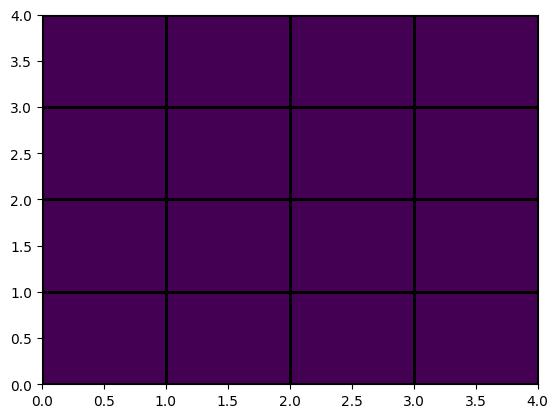

In [18]:
best_solution = max(bit_strings.items(), key=lambda x: x[-1])[0]
print(best_solution)
solution_board(best_solution)